<a href="https://colab.research.google.com/github/sperezp23/Hackaton_Ruta_n_diavetes/blob/main/Hackaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reto 3: Análisis de enfermedades a partir de datos de salud


En este notebook se desarrolla la extracción, manipulación y entrenamiento de una base de datos tomada de un hospital de Singapur para el análisis de pacientes con posibles diagnósticos de diabetes. En el siguiente se adecuan los datos para la alimentación de modelos de machine learning y se seleccione aquel que mejor se ajuste a los datos de testeo para la implementación de un método de ensamble que prediga la presencia de la enfermedad.

**Importación de librerias**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from matplotlib.colors import ListedColormap
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from google.colab import drive
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from joblib import dump
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Extracción de datos y análisis exploratorio**

Los datos utilizados se extraen desde un archivo csv guardado en una carpeta de Drive para una manipulación de datos más comoda.

In [ ]:
ruta = '/content/drive/MyDrive/Hackaton/diabetes_data_upload.csv'
diabetes_df = pd.read_csv(ruta)
diabetes_df.columns = diabetes_df.columns.str.lower().str.strip().str.replace(' ','_')
diabetes_df.sample(5)

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
72,65,Female,No,No,No,No,No,Yes,No,No,No,No,No,No,No,No,Positive
476,43,Male,No,No,No,Yes,No,Yes,No,Yes,No,Yes,No,No,Yes,No,Negative
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
463,72,Male,Yes,No,No,No,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Negative
305,40,Male,No,Yes,Yes,Yes,No,No,Yes,Yes,No,No,Yes,Yes,No,No,Negative


Distribución de edades respecto a género en casos positivos y negativos.

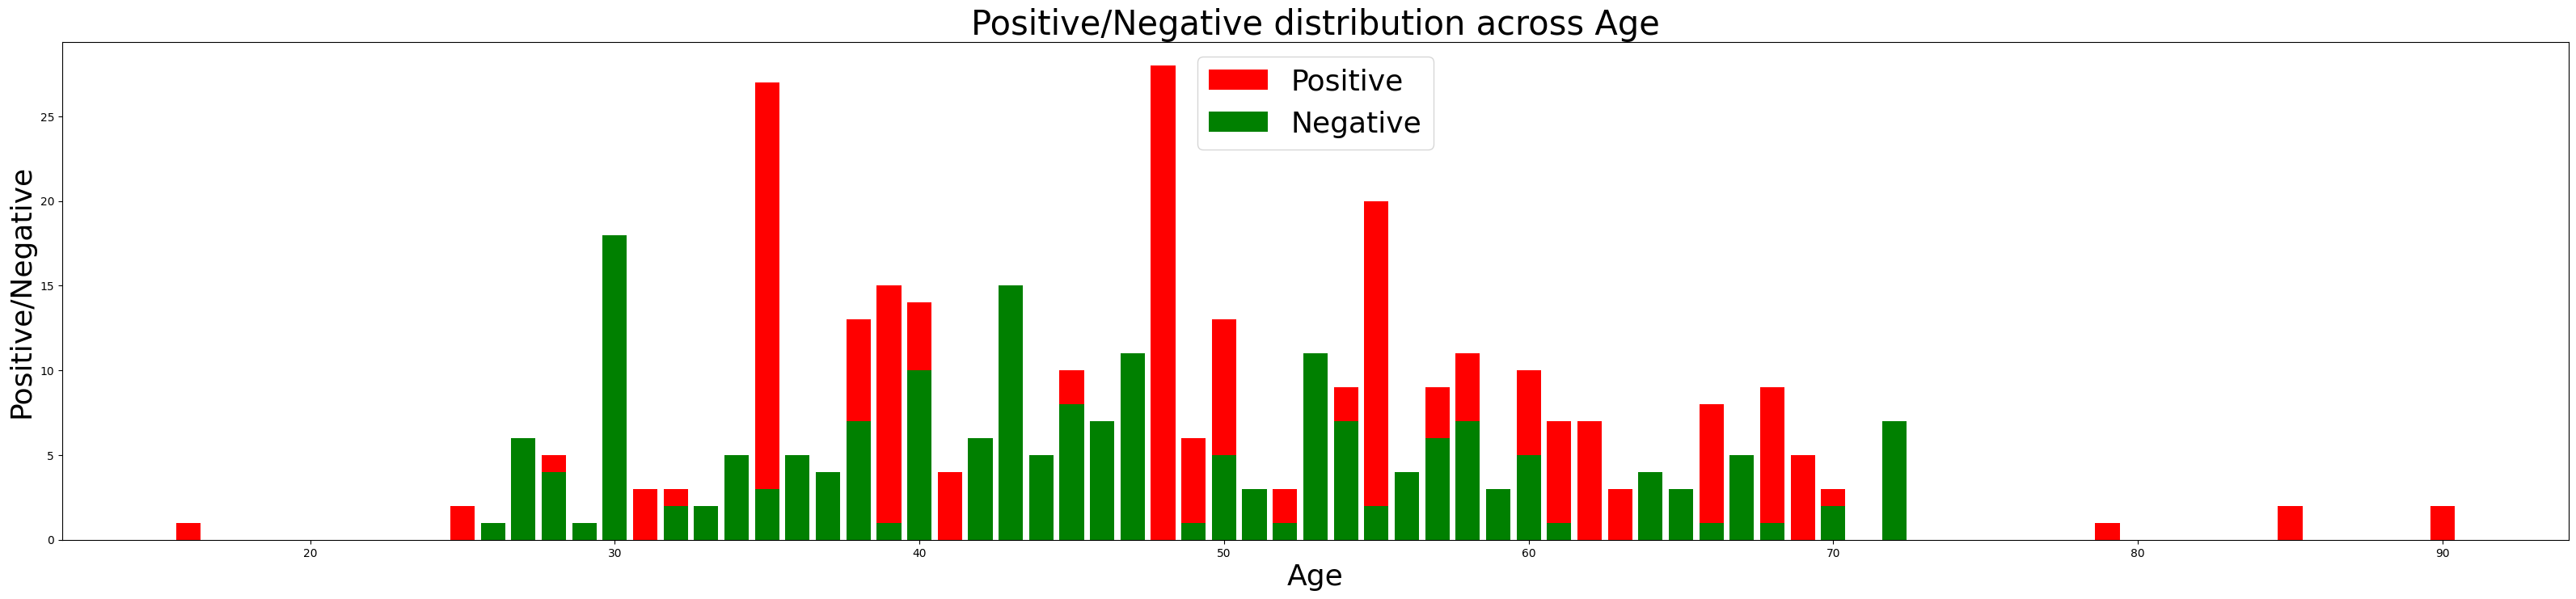

In [ ]:
Class_dict={}
for Class in diabetes_df['class'].value_counts().index:
    Class_dict[Class]=diabetes_df[diabetes_df['class']==Class]['age'].value_counts()
Class_df=pd.DataFrame(Class_dict)
Class_df.index.rename("age",inplace=True)

fig,ax1=plt.subplots(1,1,figsize=(40,8))
ax1.bar(Class_df.index,Class_df['Positive'],color="r",label="Positive")
ax1.bar(Class_df.index,Class_df['Negative'],color="g",label="Negative")

for index in Class_df.index:
    ax1.annotate(Class_df["Negative"].loc[index],xy=(index,Class_df["Negative"].loc[index]+100),ha="center",va="center",fontsize=18)
    ax1.annotate(Class_df["Positive"].loc[index],xy=(index,Class_df["Positive"].loc[index]-100),ha="center",va="center",fontsize=18)

plt.legend(fontsize=26)
plt.xlabel("Age",fontsize=26)
plt.ylabel("Positive/Negative",fontsize=26)
plt.title("Positive/Negative distribution across Age",fontsize=30)
plt.show()

Reconocimiento de características dentro de dataset.

In [ ]:
diabetes_df.columns

Index(['age', 'gender', 'polyuria', 'polydipsia', 'sudden_weight_loss',
       'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring',
       'itching', 'irritability', 'delayed_healing', 'partial_paresis',
       'muscle_stiffness', 'alopecia', 'obesity', 'class'],
      dtype='object')

Reconocimiento de tipos de datos en dataset.

In [ ]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 520 non-null    int64 
 1   gender              520 non-null    object
 2   polyuria            520 non-null    object
 3   polydipsia          520 non-null    object
 4   sudden_weight_loss  520 non-null    object
 5   weakness            520 non-null    object
 6   polyphagia          520 non-null    object
 7   genital_thrush      520 non-null    object
 8   visual_blurring     520 non-null    object
 9   itching             520 non-null    object
 10  irritability        520 non-null    object
 11  delayed_healing     520 non-null    object
 12  partial_paresis     520 non-null    object
 13  muscle_stiffness    520 non-null    object
 14  alopecia            520 non-null    object
 15  obesity             520 non-null    object
 16  class               520 no

###Preprocesamiento de datos

In [ ]:
df_bin= diabetes_df.replace({'Male':0,
                     'Female':1,
                      'Yes':1,
                     'No':0,
                     'Negative':0,
                     'Positive':1
                     })
df_bin.sample(5)

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
464,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
337,55,1,1,1,1,1,0,0,1,0,0,0,1,0,0,1,1
417,39,1,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
146,39,0,1,1,0,0,0,1,0,1,0,0,0,1,0,1,1
236,60,0,0,0,0,1,1,0,1,1,0,1,0,1,1,0,0


Medidas de estadística descriptiva

In [ ]:
df_bin.describe().round(4)

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
count,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000,520.0000
mean,48.0288,0.3692,0.4962,0.4481,0.4173,0.5865,0.4558,0.2231,0.4481,0.4865,0.2423,0.4596,0.4308,0.3750,0.3442,0.1692,0.6154
std,12.1515,0.4831,0.5005,0.4978,0.4936,0.4929,0.4985,0.4167,0.4978,0.5003,0.4289,0.4988,0.4957,0.4846,0.4756,0.3753,0.4870
min,16.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,39.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,47.5000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
75%,57.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000
max,90.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Frecuencia de datos en características

In [ ]:
for i in df_bin.columns:
  if i != 'age':
    print(df_bin[i].value_counts(normalize=0))
    print('-'*40)

0    328
1    192
Name: gender, dtype: int64
----------------------------------------
0    262
1    258
Name: polyuria, dtype: int64
----------------------------------------
0    287
1    233
Name: polydipsia, dtype: int64
----------------------------------------
0    303
1    217
Name: sudden_weight_loss, dtype: int64
----------------------------------------
1    305
0    215
Name: weakness, dtype: int64
----------------------------------------
0    283
1    237
Name: polyphagia, dtype: int64
----------------------------------------
0    404
1    116
Name: genital_thrush, dtype: int64
----------------------------------------
0    287
1    233
Name: visual_blurring, dtype: int64
----------------------------------------
0    267
1    253
Name: itching, dtype: int64
----------------------------------------
0    394
1    126
Name: irritability, dtype: int64
----------------------------------------
0    281
1    239
Name: delayed_healing, dtype: int64
--------------------------------------

Fracciones de partición de datos

In [ ]:
for i in df_bin.columns:
  if i != 'age':
    print(df_bin[i].value_counts(normalize=1))
    print('-'*40)

0    0.630769
1    0.369231
Name: gender, dtype: float64
----------------------------------------
0    0.503846
1    0.496154
Name: polyuria, dtype: float64
----------------------------------------
0    0.551923
1    0.448077
Name: polydipsia, dtype: float64
----------------------------------------
0    0.582692
1    0.417308
Name: sudden_weight_loss, dtype: float64
----------------------------------------
1    0.586538
0    0.413462
Name: weakness, dtype: float64
----------------------------------------
0    0.544231
1    0.455769
Name: polyphagia, dtype: float64
----------------------------------------
0    0.776923
1    0.223077
Name: genital_thrush, dtype: float64
----------------------------------------
0    0.551923
1    0.448077
Name: visual_blurring, dtype: float64
----------------------------------------
0    0.513462
1    0.486538
Name: itching, dtype: float64
----------------------------------------
0    0.757692
1    0.242308
Name: irritability, dtype: float64
-------------

In [ ]:
print (np.unique(diabetes_df['class'], return_counts=True))

(array(['Negative', 'Positive'], dtype=object), array([200, 320]))


Varianza

In [ ]:
diabetes_df.var()

<ipython-input-11-4e1dac7b85e0>:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  diabetes_df.var()


age    147.658126
dtype: float64

Correlación de los datos

<Axes: >

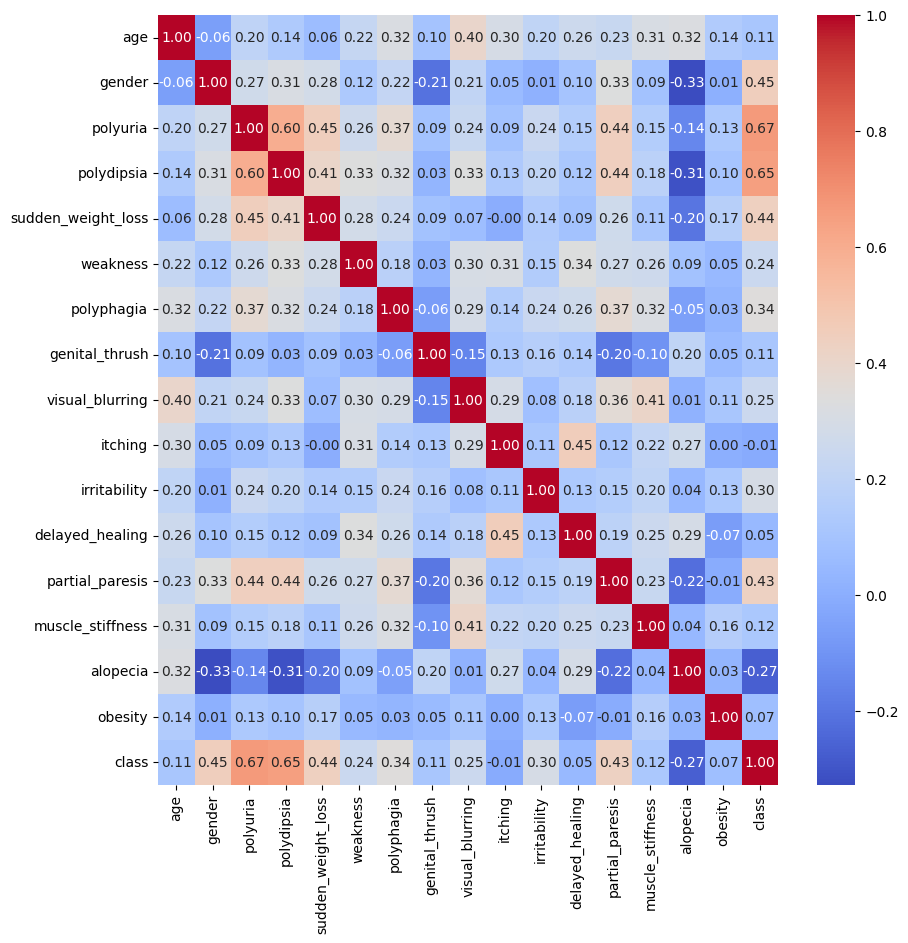

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
sns.heatmap(df_bin.corr(),annot=True, fmt=".2f", cmap='coolwarm')

Del gráfico anterior se observa una correlación fuerte entre el género, síntomas de poliuria, síntomas de polidipsia, rápida pérdida de peso, síntomas de parálisis parcial y síntomas de polifagia, por ende, las características presentadas anteriormente representarán pesos mayores para la predicción de la respuesta.

**Distribuciones de frecuencia en géneros**

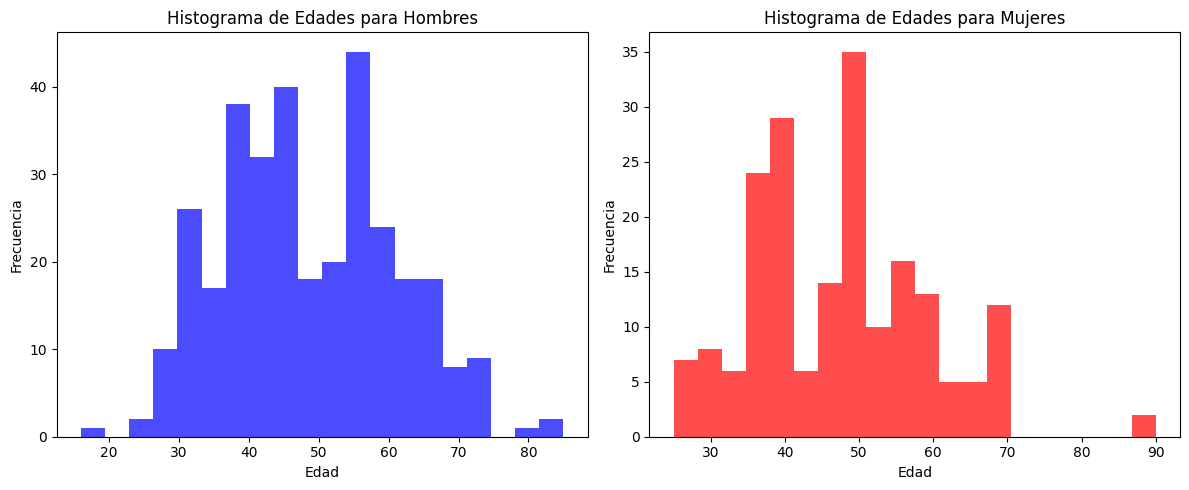

In [ ]:
edades_hombres = df_bin[df_bin['gender'] == 0]['age']
edades_mujeres = df_bin[df_bin['gender'] == 1]['age']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas

# Dibujar el histograma de hombres
axs[0].hist(edades_hombres, bins=20, color='blue', alpha=0.7)
axs[0].set_title('Histograma de Edades para Hombres')
axs[0].set_xlabel('Edad')
axs[0].set_ylabel('Frecuencia')

# Dibujar el histograma de mujeres
axs[1].hist(edades_mujeres, bins=20, color='red', alpha=0.7)
axs[1].set_title('Histograma de Edades para Mujeres')
axs[1].set_xlabel('Edad')
axs[1].set_ylabel('Frecuencia')

# Ajustar la disposición de los subgráficos
plt.tight_layout()

# Mostrar los subgráficos
plt.show()

# Modelo machine learning

##Spliteo de los datos

In [ ]:
test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(df_bin.iloc[0:,:-1], df_bin.iloc[:,-1], test_size=test_size)

In [ ]:
X_train

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity
234,52,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0
435,57,0,1,1,1,1,1,0,1,0,0,0,1,0,0,0
195,31,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0
89,35,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
353,60,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,57,0,0,1,0,1,0,1,1,0,1,1,1,1,1,0
335,53,0,0,0,0,1,1,0,1,1,0,1,1,1,1,0
436,41,0,1,1,1,1,1,1,1,1,1,0,0,0,0,1
306,28,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Reconocimiento de dimensiones

In [ ]:
df_bin.iloc[:,-1].shape

(520,)

In [ ]:
df_bin.iloc[0:,1:].drop("class", axis=1).shape

(520, 15)

In [ ]:
y_real = df_bin.iloc[:,-1]

In [ ]:
np.unique(y_test, return_counts=True)
print (X_train.shape)

(364, 16)


Transformación de datos bajo PCA

[9.78280104e-01 5.66191857e-03 2.60509136e-03 1.91739296e-03
 1.50571001e-03 1.42118851e-03 1.28219897e-03 1.10075693e-03
 9.36458040e-04 9.12556856e-04 9.01457947e-04 7.88351498e-04
 7.62845509e-04 7.22103377e-04 6.86022887e-04]


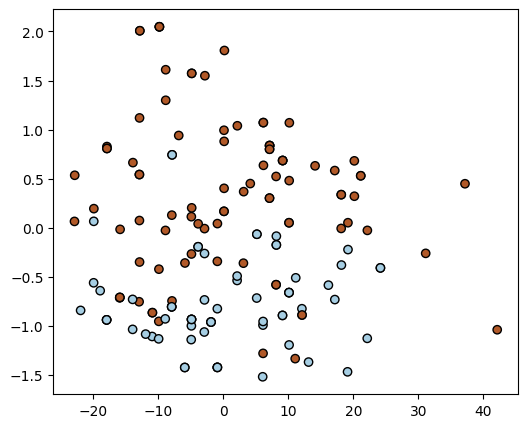

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform (X_test)
print (pca.explained_variance_ratio_)

_, ax =plt.subplots(figsize=(6,5))
ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='Paired', edgecolors='k')

Bajo la transformación de datos en PCA se reduce la dimensionalidad del modelo,permitiendo una mejor visualización e interpretación de los patrones de datos, además muestra una clasificación adecuada de los datos.

Matriz de confusión en testeo

LogisticRegression(C=1)


<Axes: >

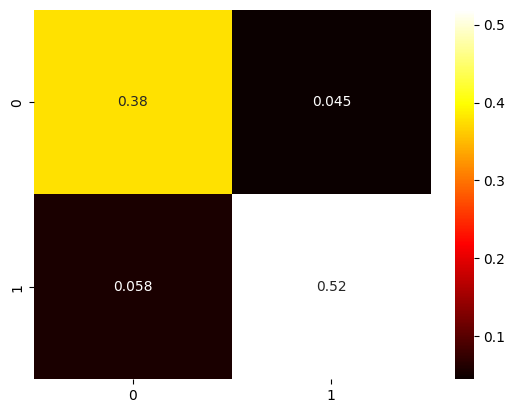

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

clf = LogisticRegression()
param_dist = {
    "C": (0.0001, 0.001, 0.01, 0.1, 1, 10, 100)
}

rs = RandomizedSearchCV(clf, param_dist, scoring='f1', cv=8, n_iter=5)

rs.fit(X_train_pca, y_train)

print(rs.best_estimator_)

predictions = rs.best_estimator_.predict(X_test_pca)

cm= confusion_matrix(y_test, predictions, normalize = "all")
sns.heatmap(cm, annot=True, cmap='hot')

Matriz de confusión en entrenamiento

<Axes: >

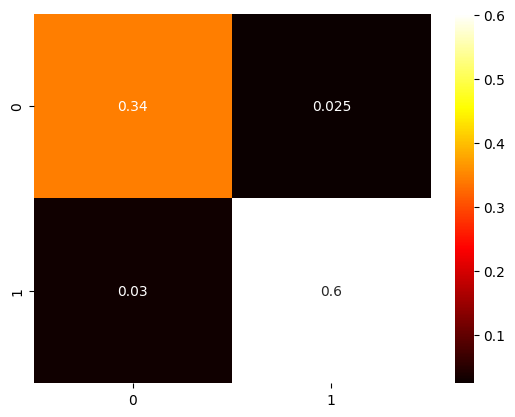

In [ ]:
predictions = rs.best_estimator_.predict(X_train_pca)

cm= confusion_matrix(y_train, predictions, normalize = "all")
sns.heatmap(cm, annot=True, cmap='hot')

Dadas las matrices de confusión observadas en los datos de testeo y entrenamiento se puede concluir que el modelo clasifica de manera adecuada las instancias al presentar falsos positivos y falsos negativos cercanos a cero.

### Modelo árboles de Decisión

Uso de GridSearchCV para optimización de parámetros

In [ ]:
clf = DecisionTreeClassifier()

param_grid = {
    "max_depth": (1, 2, 3, 4),
    "min_samples_leaf": (1, 2, 3),
    "criterion": ["gini", "entropy"]
}

gs = GridSearchCV(clf, param_grid, scoring='accuracy', cv=8)

gs.fit(X_train_pca, y_train)

best_grid_param = gs.best_params_
best_grid_score = gs.best_score_
print("La combinación de hiperparámetros para árboles de Decisión que mejor resultado entrega es", (best_grid_param))
print("La métrica que mejor ajusta los datos para el modelo de árboles de Decisión es de:", best_grid_score)

La combinación de hiperparámetros para árboles de Decisión que mejor resultado entrega es {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}
La métrica que mejor ajusta los datos para el modelo de árboles de Decisión es de: 0.9147342995169082


Puntaje de validación cruzada para el modelo de arboles de decisión

In [ ]:
clf = DecisionTreeClassifier(max_depth=4)

scores = cross_val_score(
    clf,
    X_train_pca,
    y_train,
    scoring='f1',
    cv=5,
    n_jobs=1
)

mean_score = np.mean(scores)

std = np.std(scores)

msg = "El puntaje de validación cruzada es de {:.2f} +/- {:.4f}"
print(msg.format(mean_score, std))

El puntaje de validación cruzada es de 0.92 +/- 0.0338


Desarrollo de curva de validación para árboles de decisión

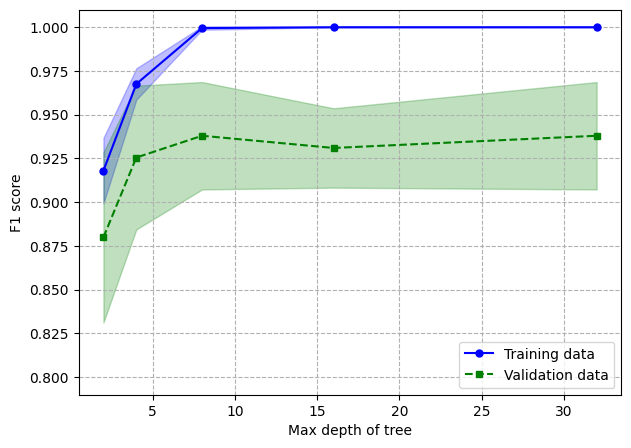

In [ ]:
clf = DecisionTreeClassifier()

param_name = 'max_depth'

param_range = (2, 4, 8, 16, 32)

train_scores, val_scores = validation_curve(
    clf,
    X_train_pca,
    y_train,
    param_name=param_name,
    param_range=param_range,
    cv=10,
    scoring='f1',
    n_jobs=1
)

mean_train_scores = np.mean(train_scores, axis=1)
mean_val_scores = np.mean(val_scores, axis=1)

std_train_scores = np.std(train_scores, axis=1)
std_val_scores = np.std(val_scores, axis=1)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

ax.plot(
    param_range, mean_train_scores, color='blue',
    marker='o', linestyle='-', markersize=5,
    label='Training data'
)

ax.fill_between(
    param_range, mean_train_scores + std_train_scores,
    mean_train_scores - std_train_scores, alpha=0.25,
    color='blue'
)

ax.plot(
    param_range, mean_val_scores, color='green',
    marker='s', linestyle='--', markersize=5,
    label='Validation data'
)

ax.fill_between(
    param_range, mean_val_scores + std_val_scores,
    mean_val_scores - std_val_scores, alpha=0.25,
    color='green'
)

ax.set_xlabel('Max depth of tree')
ax.set_ylabel('F1 score')

min_train_scores = np.min(train_scores)
min_val_scores = np.min(val_scores)

ax.set_ylim(min(min_train_scores, min_val_scores) - 0.01, 1.01)
ax.grid(linestyle='--')
ax.legend(loc='lower right')

Curva de aprendizaje para árboles de decisión

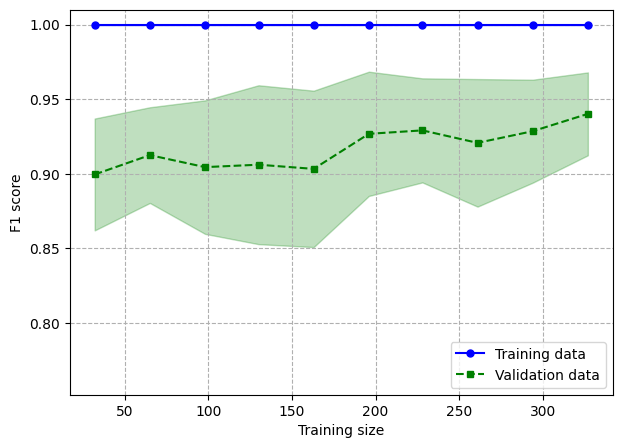

In [ ]:
clf = DecisionTreeClassifier()

train_sizes = np.linspace(0.1, 1, 10)

train_sizes_abs, train_scores, val_scores = learning_curve(
    clf,
    X_train_pca,
    y_train,
    train_sizes=train_sizes,
    cv=10,
    scoring='f1',
    n_jobs=1,
)

mean_train_scores = np.mean(train_scores, axis=1)
mean_val_scores = np.mean(val_scores, axis=1)

std_train_scores = np.std(train_scores, axis=1)
std_val_scores = np.std(val_scores, axis=1)


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

ax.plot(
    train_sizes_abs, mean_train_scores, color='blue',
    marker='o', linestyle='-', markersize=5,
    label='Training data'
)

ax.fill_between(
    train_sizes_abs, mean_train_scores + std_train_scores,
    mean_train_scores - std_train_scores, alpha=0.25,
    color='blue'
)

ax.plot(
    train_sizes_abs, mean_val_scores, color='green',
    marker='s', linestyle='--', markersize=5,
    label='Validation data'
)

ax.fill_between(
    train_sizes_abs, mean_val_scores + std_val_scores,
    mean_val_scores - std_val_scores, alpha=0.25,
    color='green'
)

ax.set_xlabel('Training size')
ax.set_ylabel('F1 score')

min_train_scores = np.min(train_scores)
min_val_scores = np.min(val_scores)

ax.set_ylim(min(min_train_scores, min_val_scores) - 0.01, 1.01)
ax.grid(linestyle='--')
ax.legend(loc='lower right')

### Modelo XGboost

Uso de GridSearchCV para optimización de parámetros

In [ ]:
clf = XGBClassifier()

param_grid = {
    "learning_rate": (0.0005, 0.05, 0.1, 1, 10),
    "n_estimators": (50,100,200),
    "max_depth": (3,5,10)
}

gs = GridSearchCV(clf, param_grid, scoring='accuracy', cv=8)

gs.fit(X_train_pca, y_train)

best_grid_param = gs.best_params_
best_grid_score = gs.best_score_
print("La combinación de hiperparámetros para XGBoost que mejor resultado entrega es", (best_grid_param))
print("La métrica que mejor ajusta los datos para el modelo XGBoost es de:", best_grid_score)

La combinación de hiperparámetros para XGBoost que mejor resultado entrega es {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
La métrica que mejor ajusta los datos para el modelo XGBoost es de: 0.9448067632850242


Puntaje de validación cruzada para el modelo de XGBoost

In [ ]:
clf = XGBClassifier(learning_rate=0.1)

scores = cross_val_score(
    clf,
    X_train_pca,
    y_train,
    scoring='f1',
    cv=5,
    n_jobs=1
)

mean_score = np.mean(scores)

std = np.std(scores)

msg = "El puntaje de validación cruzada es de {:.2f} +/- {:.4f}"
print(msg.format(mean_score, std))

El puntaje de validación cruzada es de 0.96 +/- 0.0214


Curva de aprendizaje para XGBoost

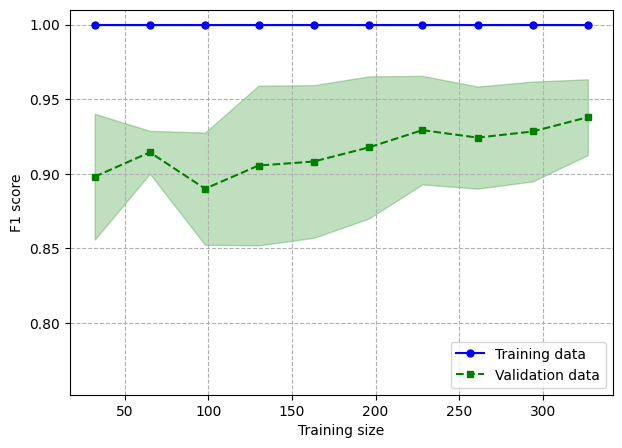

In [ ]:
clf = DecisionTreeClassifier()

train_sizes = np.linspace(0.1, 1, 10)

train_sizes_abs, train_scores, val_scores = learning_curve(
    clf,
    X_train_pca,
    y_train,
    train_sizes=train_sizes,
    cv=10,
    scoring='f1',
    n_jobs=1,
)

mean_train_scores = np.mean(train_scores, axis=1)
mean_val_scores = np.mean(val_scores, axis=1)

std_train_scores = np.std(train_scores, axis=1)
std_val_scores = np.std(val_scores, axis=1)


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

ax.plot(
    train_sizes_abs, mean_train_scores, color='blue',
    marker='o', linestyle='-', markersize=5,
    label='Training data'
)

ax.fill_between(
    train_sizes_abs, mean_train_scores + std_train_scores,
    mean_train_scores - std_train_scores, alpha=0.25,
    color='blue'
)

ax.plot(
    train_sizes_abs, mean_val_scores, color='green',
    marker='s', linestyle='--', markersize=5,
    label='Validation data'
)

ax.fill_between(
    train_sizes_abs, mean_val_scores + std_val_scores,
    mean_val_scores - std_val_scores, alpha=0.25,
    color='green'
)

ax.set_xlabel('Training size')
ax.set_ylabel('F1 score')

min_train_scores = np.min(train_scores)
min_val_scores = np.min(val_scores)

ax.set_ylim(min(min_train_scores, min_val_scores) - 0.01, 1.01)
ax.grid(linestyle='--')
ax.legend(loc='lower right')

### Modelo regresión Logistica

Uso de GridSearchCV para optimización de parámetros

In [ ]:
clf = LogisticRegression()

param_grid = {
    "penalty":['l1', 'l2'],
    "C": (0.5, 1, 3)
}

gs = GridSearchCV(clf, param_grid, scoring='accuracy', cv=8)

gs.fit(X_train_pca, y_train)

best_grid_param = gs.best_params_
best_grid_score = gs.best_score_
print("La combinación de hiperparámetros para Regresión logística mejor resultado entrega es", (best_grid_param))
print("La métrica que mejor ajusta los datos para el modelo de Regresión logística es de:", best_grid_score)

La combinación de hiperparámetros para Regresión logística mejor resultado entrega es {'C': 1, 'penalty': 'l2'}
La métrica que mejor ajusta los datos para el modelo de Regresión logística es de: 0.9283816425120772


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Puntaje de validación cruzada para el modelo de Regresión logística

In [ ]:
clf = LogisticRegression(C=0.5)

scores = cross_val_score(
    clf,
    X_train_pca,
    y_train,
    scoring='f1',
    cv=5,
    n_jobs=1
)

mean_score = np.mean(scores)

std = np.std(scores)

msg = "El puntaje de validación cruzada es de {:.2f} +/- {:.4f}"
print(msg.format(mean_score, std))

El puntaje de validación cruzada es de 0.94 +/- 0.0450


Curva de aprendizaje para Regresión logística

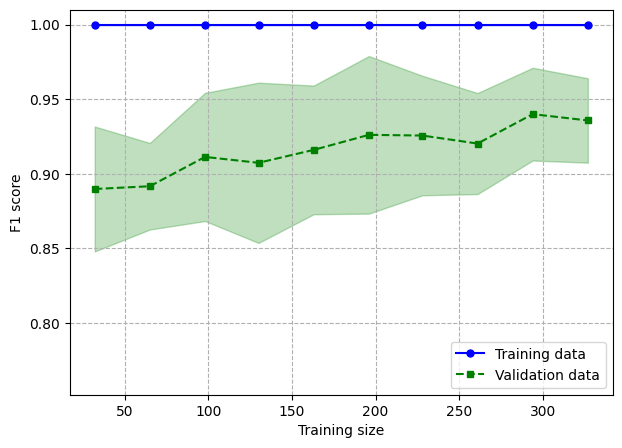

In [ ]:
clf = DecisionTreeClassifier()

train_sizes = np.linspace(0.1, 1, 10)

train_sizes_abs, train_scores, val_scores = learning_curve(
    clf,
    X_train_pca,
    y_train,
    train_sizes=train_sizes,
    cv=10,
    scoring='f1',
    n_jobs=1,
)

mean_train_scores = np.mean(train_scores, axis=1)
mean_val_scores = np.mean(val_scores, axis=1)

std_train_scores = np.std(train_scores, axis=1)
std_val_scores = np.std(val_scores, axis=1)


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

ax.plot(
    train_sizes_abs, mean_train_scores, color='blue',
    marker='o', linestyle='-', markersize=5,
    label='Training data'
)

ax.fill_between(
    train_sizes_abs, mean_train_scores + std_train_scores,
    mean_train_scores - std_train_scores, alpha=0.25,
    color='blue'
)

ax.plot(
    train_sizes_abs, mean_val_scores, color='green',
    marker='s', linestyle='--', markersize=5,
    label='Validation data'
)

ax.fill_between(
    train_sizes_abs, mean_val_scores + std_val_scores,
    mean_val_scores - std_val_scores, alpha=0.25,
    color='green'
)

ax.set_xlabel('Training size')
ax.set_ylabel('F1 score')

min_train_scores = np.min(train_scores)
min_val_scores = np.min(val_scores)

ax.set_ylim(min(min_train_scores, min_val_scores) - 0.01, 1.01)
ax.grid(linestyle='--')
ax.legend(loc='lower right')

###Modelo SVC

Uso de GridSearchCV para optimización de parámetros

In [ ]:
clf = SVC()

param_grid = {
    "C": (0.5, 1, 3),
    "kernel": ['rbf', 'linear', 'poly', 'sigmoid']
}

gs = GridSearchCV(clf, param_grid, scoring='accuracy', cv=8)

gs.fit(X_train_pca, y_train)

best_grid_param = gs.best_params_
best_grid_score = gs.best_score_
print("La combinación de hiperparámetros para SVC que mejor resultado entrega es", (best_grid_param))
print("La métrica que mejor ajusta los datos para el modelo de SVC es de:", best_grid_score)

La combinación de hiperparámetros para SVC que mejor resultado entrega es {'C': 0.5, 'kernel': 'linear'}
La métrica que mejor ajusta los datos para el modelo de SVC es de: 0.9367149758454106


Puntaje de validación cruzada para el modelo de SVC

In [ ]:
clf = SVC(C=0.5)

scores = cross_val_score(
    clf,
    X_train_pca,
    y_train,
    scoring='f1',
    cv=5,
    n_jobs=1
)

mean_score = np.mean(scores)

std = np.std(scores)

msg = "El puntaje de validación cruzada es de {:.2f} +/- {:.4f}"
print(msg.format(mean_score, std))

El puntaje de validación cruzada es de 0.79 +/- 0.0238


Dadas las mediciones arrojadas de los modelos anteriores seleccionamos el modelo con mejor métrica.

###Predicción con ensamble Adaboost con modelo de mejor puntaje en métrica de selección

In [ ]:
adaboost_model = AdaBoostClassifier(base_estimator=LogisticRegression())

In [ ]:
adaboost_model.fit(X_train_pca, y_train)

y_train_pred = adaboost_model.predict(X_train_pca)
y_test_pred = adaboost_model.predict(X_test_pca)

f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print('f1 para AdaBoost en train {}'.format(f1_train))
print('f1 para AdaBoost  en test {}'.format(f1_test))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


f1 para AdaBoost en train 0.9469026548672567
f1 para AdaBoost  en test 0.9090909090909092


Del modelo anterior se observa que el modelo tiene un 95.65% de precisión entre datos de testeo y predichos para la métrica F1, lo que indica un alto valor de confiabilidad entre los valores predichos para diferentes entradas.

###Despliegue del modelo

In [ ]:
dumb_adaboost = pickle.dumps(adaboost_model)
load_adaboost = pickle.loads(dumb_adaboost)
adaboost_prediction = load_adaboost.predict(X_train_pca)
save_pred = dump(adaboost_model, '/content/drive/MyDrive/Hackaton/Adaboost_pred.joblib')

Luego de tener el modelo de predicción entrenado y bajo una métrica de precisión entre datos de testeo y predichos, se guarda para implementación en el sistema Front-Back según los datos de entrada.